Author: Yoseph Loyd
Date 20241212

Developement of a means to segment capilarries in tissue images. This is intended to be ported through the ChimeraX visualizer.

###initial commands for ChimaraX input test date###

open "C:/Users/LoydY/OneDrive - SUNY Upstate Medical University/Documents/20240917_006/006_decon_capillaries.tif";

volume #1 style surface step 2 level 1.449e+04;
volume #1 voxelSize 1,1,1.5 style surface;
marker #2 position 554.9,779.1,71.11 color yellow radius 1;
lighting depthcue false;

ui tool show shell

Python functions imports

In [ ]:
from chimerax.map_data import ArrayGridData 
from chimerax.map import volume_from_grid_data
import itertools
import numpy
import scipy
import skimage
from time import time
"""import numba"""
"""import multiprocessing"""

Identification and rescaling of imagein ChimeraX ENV.

In [ ]:
y=session.models[2].volume.full_matrix().copy()
p= session.models[3].atoms.coords
p=numpy.round(p).astype('int')

matrix=numpy.zeros((numpy.shape(y)))
a=numpy.linspace(p[0,0]-80,p[0,0]+80, 161)
b=numpy.linspace(p[0,1]-80,p[0,1]+80, 161)
c=numpy.linspace((p[0,2]/1.5)-44,(p[0,2]/1.5)+27, 72)

q=numpy.array(list(itertools.product(*(a,b,c),repeat=1)),dtype='int')
w=numpy.split(q,3,1)
matrix[w[2],w[1],w[0]]=1
mask=ArrayGridData(matrix,step=(1,1,1.5))
volume_from_grid_data(mask,session)

Using the Bernsens auto thresholding approach I'll segement capillary walls in the ROI while using an auto global contrast threshold variable.

In [ ]:

welp=matrix*y
welp[welp==0] = numpy.nan

radius=3
cl=numpy.nanmean(welp)*1.15
help= numpy.zeros(numpy.shape(welp))
for h in range(numpy.min(w[2]),numpy.max(w[2])):
    for g in range(numpy.min(w[1]),numpy.max(w[1])):
        for f in range(numpy.min(w[0]),numpy.max(w[0])):
            fl=numpy.int32(numpy.linspace(f-radius,radius+f, 2*radius+1))-1
            gl=numpy.int32(numpy.linspace(g-radius,radius+g, 2*radius+1))-1
            hl=numpy.int32(numpy.linspace(h-radius,radius+h, 2*radius+1))-1
            if numpy.isnan((welp[hl,gl,fl].all()))==False:
                standardD = numpy.nanstd(welp[hl,gl,fl])*0.15
                Thresh= ((numpy.nanmax(welp[hl,gl,fl])-numpy.nanmin(welp[hl,gl,fl]))/2)+standardD
                contrast= (numpy.nanmax(welp[hl,gl,fl])-numpy.nanmin(welp[hl,gl,fl]))
            else:
                help = numpy.nan
            
            if  contrast < cl:
                welp[h,g,f]= 0
            else:
                welp[h,g,f]= welp[h,g,f]
            
            if welp[h,g,f] >= (Thresh):
                help[h,g,f]= 1
            else:
                help[h,g,f]=0

Improved masking though there is some stripping in the mask due to image fluctuations in stripped podocyte image

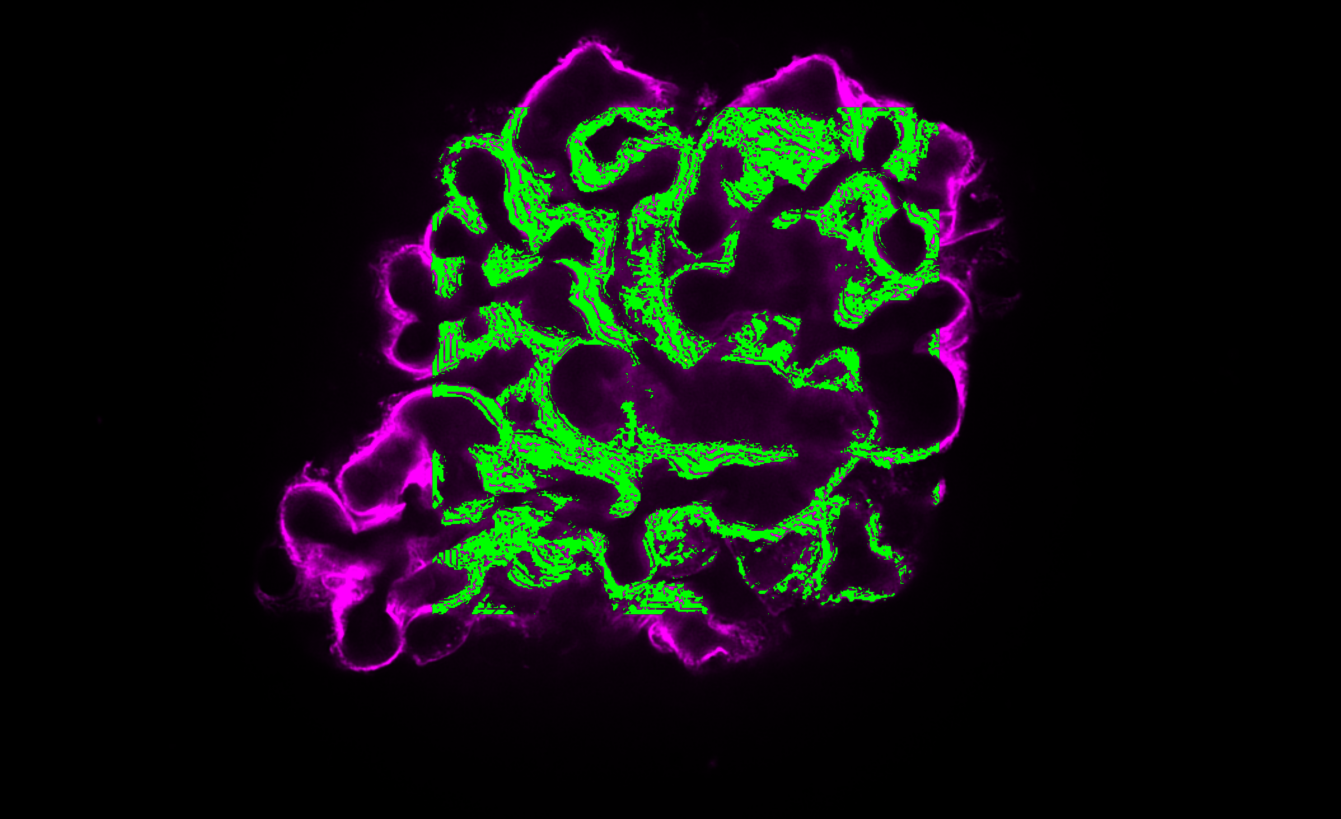

In [ ]:
import skimage.morphology


telp = skimage.morphology.erosion(help)
telp = skimage.morphology.dilation(telp)
telp = skimage.morphology.dilation(telp)
telp = skimage.morphology.dilation(telp)

The same processing on capilarry images seems to work similarly. and gaps are filled in with 1 inital erosion and 3 subsequent dilation operations.

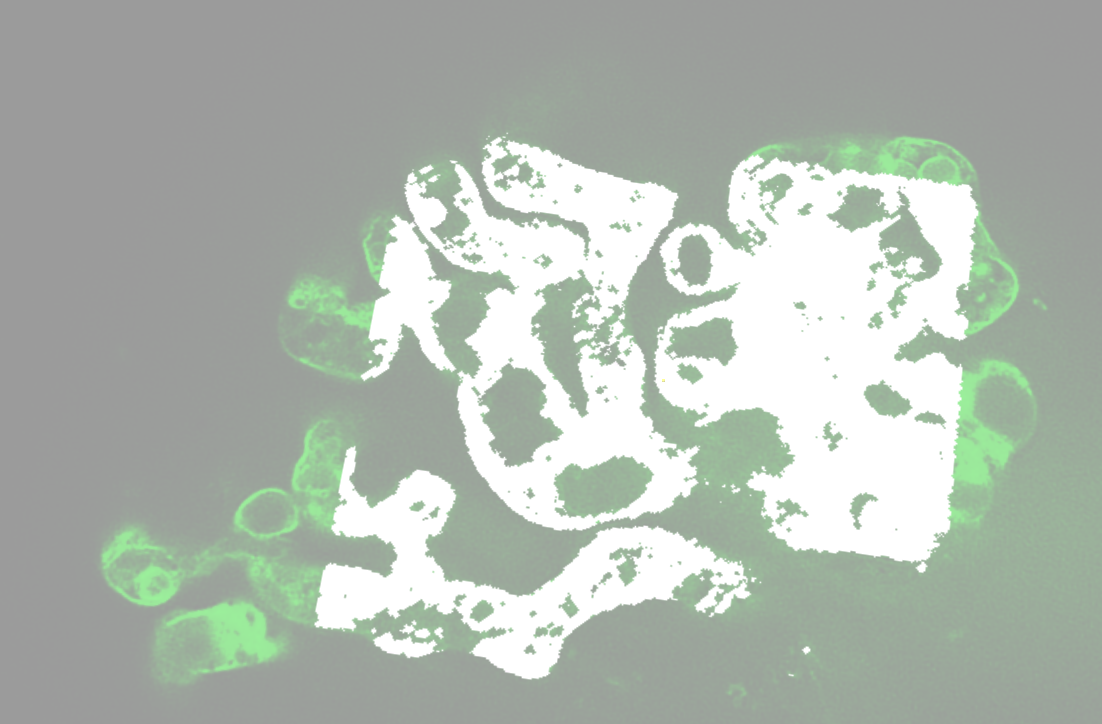

In [ ]:
mw= numpy.min(w[2])
mxw= numpy.max(w[2])
closed= numpy.zeros(numpy.shape(telp))
for n in range (mw,mxw):
    closed[n,:,:] = skimage.morphology.diameter_closing(telp[n,:,:],diameter_threshold=800)

diameter closing opperation in 3d appears to take a long time results from it are poor when sliding in the z axis. Transitionsing this to a 2d iterative approach improved closing function still not a refined and optimal approach but it shows diseirable progress. glom membrane is in orange, the magenta mask is diameter closed region, and the green mask is the inital masking of the capilarries

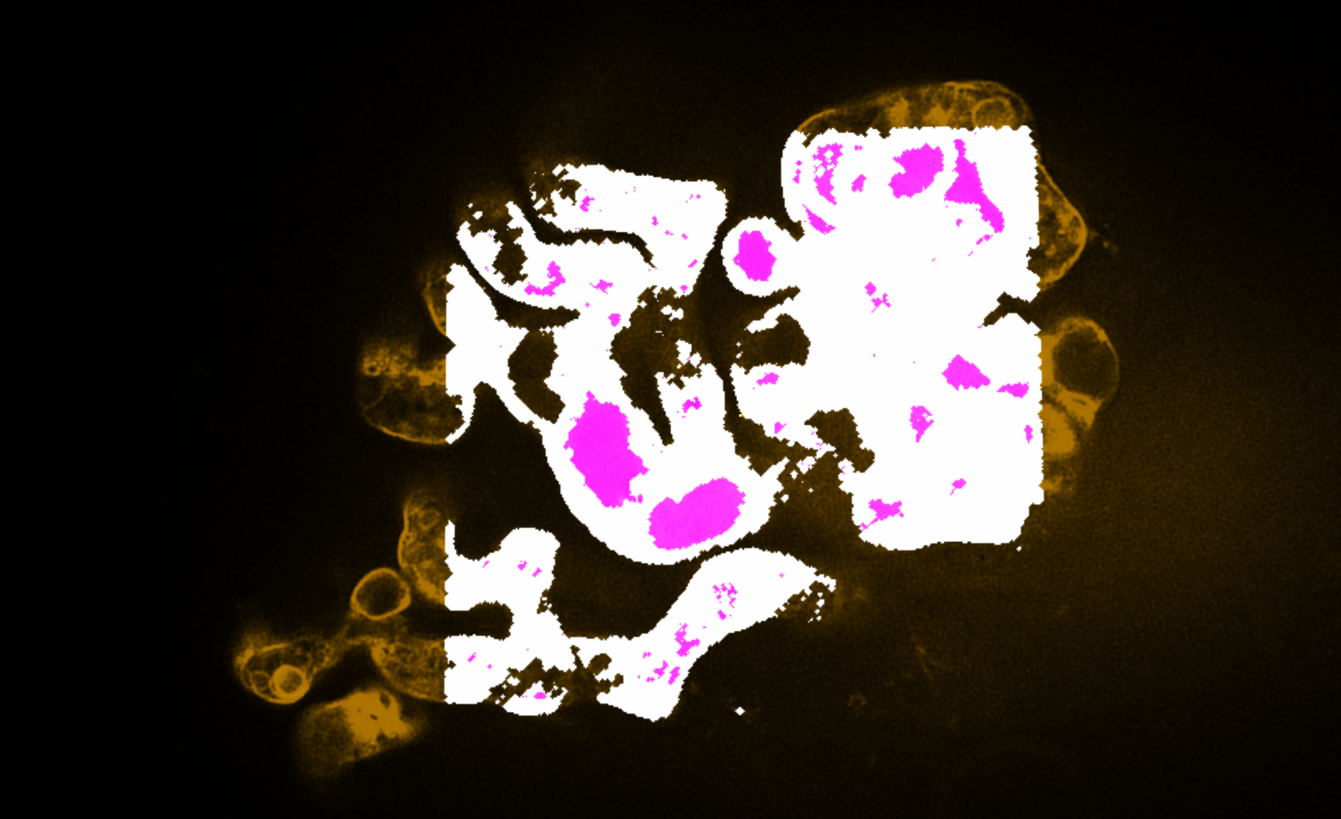
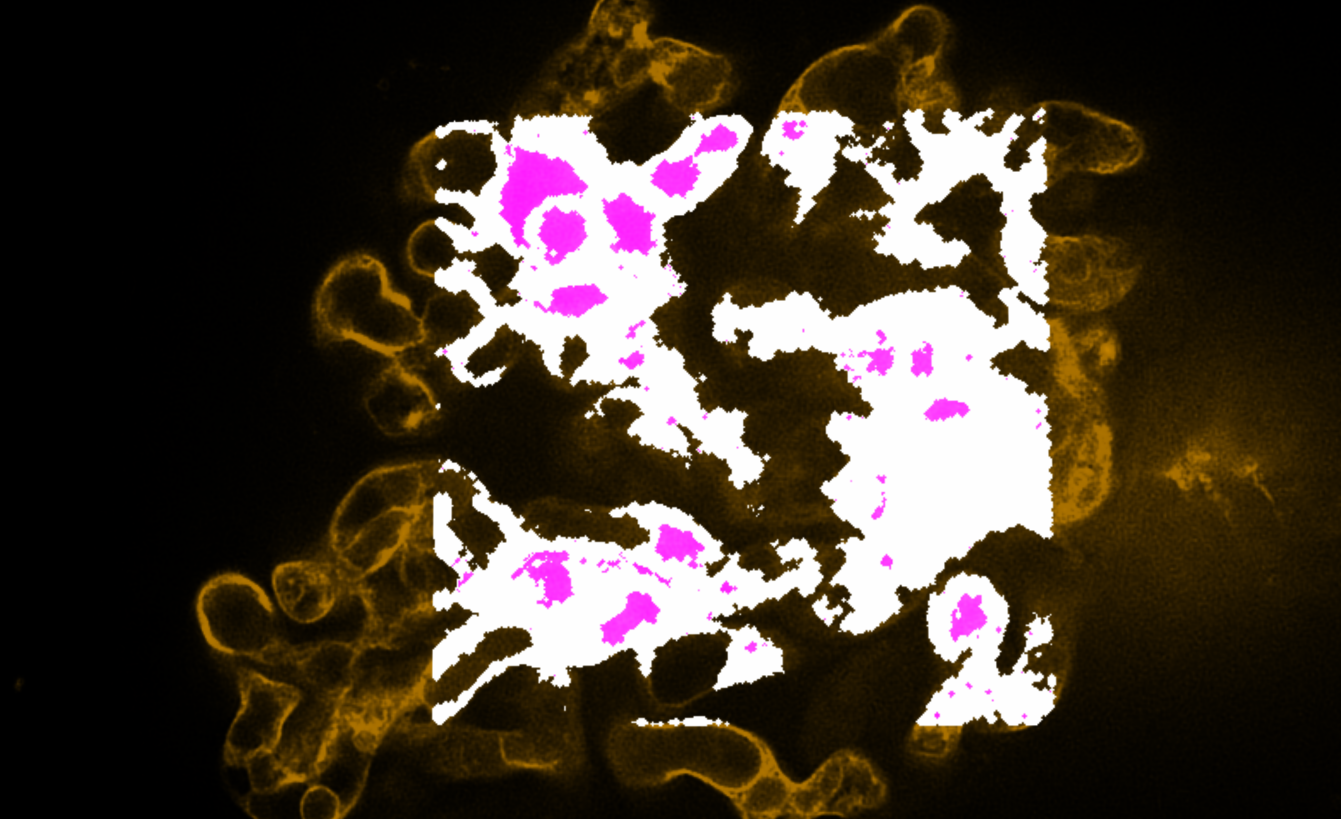

Author: Yoseph  
Date: 20241219

Objective parallel operation for initial for loop in nest loop series

In [ ]:
y=session.models[2].volume.full_matrix().copy()
p= session.models[3].atoms.coords
p=numpy.round(p).astype('int')

matrix=numpy.zeros((numpy.shape(y)))
a=numpy.linspace(p[0,0]-250,p[0,0]+250, 501)
b=numpy.linspace(p[0,1]-250,p[0,1]+250, 5011)
c=numpy.linspace((p[0,2]/1.5)-44,(p[0,2]/1.5)+27, 72)

q=numpy.array(list(itertools.product(*(a,b,c),repeat=1)),dtype='int')
w=numpy.split(q,3,1)
matrix[w[2],w[1],w[0]]=1

In [ ]:
start=time()

welp=matrix*y
welp[welp==0] = numpy.nan

radius=3
cl=numpy.nanmean(welp)*1.15
help= numpy.zeros(numpy.shape(welp))

for h in range(numpy.min(w[2]),numpy.max(w[2])):
    for g in range(numpy.min(w[1]),numpy.max(w[1])):
        for f in range(numpy.min(w[0]),numpy.max(w[0])):
            fl=numpy.int32(numpy.linspace(f-radius,radius+f, 2*radius+1))-1
            gl=numpy.int32(numpy.linspace(g-radius,radius+g, 2*radius+1))-1
            hl=numpy.int32(numpy.linspace(h-radius,radius+h, 2*radius+1))-1
            if numpy.isnan((welp[hl,gl,fl].all()))==False:
                standardD = numpy.nanstd(welp[hl,gl,fl])*0.15
                Thresh= ((numpy.nanmax(welp[hl,gl,fl])-numpy.nanmin(welp[hl,gl,fl]))/2)+standardD
                contrast= (numpy.nanmax(welp[hl,gl,fl])-numpy.nanmin(welp[hl,gl,fl]))
            else:
                help = numpy.nan
            
            if  contrast < cl:
                welp[h,g,f]= 0
            else:
                welp[h,g,f]= welp[h,g,f]
            
            if welp[h,g,f] >= (Thresh):
                help[h,g,f]= 1
            else:
                help[h,g,f]=0

end=time()
print(end - start)

In [ ]:
from numba import njit, prange
from time import time
start=time()

welp=matrix*y
welp[welp==0] = numpy.nan
radius=3
cl=numpy.nanmean(welp)*1.15
@njit(parallel=True, nopython=True)
def FastAT(welp,w,cl):
    n= numpy.max(w[0])-numpy.min(w[0])
    help= numpy.zeros(numpy.shape(welp))
    for h in range(numpy.min(w[2]),numpy.max(w[2])):
        for g in range(numpy.min(w[1]),numpy.max(w[1])):
            for f in prange(n):
                fn=f+numpy.min(w[0])
                fl=(numpy.linspace(fn-radius,radius+fn, 2*radius+1).astype(numpy.int32))-1
                gl=(numpy.linspace(g-radius,radius+g, 2*radius+1).astype(numpy.int32))-1
                hl=(numpy.linspace(h-radius,radius+h, 2*radius+1).astype(numpy.int32))-1
                if numpy.isnan((welp[hl,gl,fl].all()))==False:
                    standardD = numpy.nanstd(welp[hl,gl,fl])*0.15
                    Thresh= ((numpy.nanmax(welp[hl,gl,fl])-numpy.nanmin(welp[hl,gl,fl]))/2)+standardD
                    contrast= (numpy.nanmax(welp[hl,gl,fl])-numpy.nanmin(welp[hl,gl,fl]))
                else:
                    help = -1
                
                if  contrast < cl:
                    welp[h,g,fn]= 0
                else:
                    welp[h,g,fn]= welp[h,g,f]
                
                if welp[h,g,fn] >= (Thresh):
                    help[h,g,fn]= 1
                else:
                    help[h,g,fn]=0
    return (help)

pelp= numpy.array(welp,‘C’, dtype(numpy.float64))
help = FastAT(pelp,w,cl)

end=time()
print(end - start)

numba iterable needs a very specific structure for objects will need to spend work to convert current implementation of function

Multi process method

In [ ]:
from multiprocessing  import Process

start=time()
welp=matrix*y
welp[welp==0] = numpy.nan
radius=3
cl=numpy.nanmean(welp)*1.15
help= numpy.zeros(numpy.shape(welp))
def multipro(f):
    for h in range(numpy.min(w[2]),numpy.max(w[2])):
        for g in range(numpy.min(w[1]),numpy.max(w[1])):
        
            fl=numpy.int32(numpy.linspace(f-radius,radius+f, 2*radius+1))-1
            gl=numpy.int32(numpy.linspace(g-radius,radius+g, 2*radius+1))-1
            hl=numpy.int32(numpy.linspace(h-radius,radius+h, 2*radius+1))-1
            if numpy.isnan((welp[hl,gl,fl].all()))==False:
                standardD = numpy.nanstd(welp[hl,gl,fl])*0.15
                Thresh= ((numpy.nanmax(welp[hl,gl,fl])-numpy.nanmin(welp[hl,gl,fl]))/2)+standardD
                contrast= (numpy.nanmax(welp[hl,gl,fl])-numpy.nanmin(welp[hl,gl,fl]))
            else:
                help = numpy.nan
            
            if  contrast < cl:
                welp[h,g,f]= 0
            else:
                welp[h,g,f]= welp[h,g,f]
            
            if welp[h,g,f] >= (Thresh):
                help[h,g,f]= 1
            else:
                help[h,g,f]=0
    return help[:,:,f]


if __name__ == "__main__": 
    arr=range (numpy.min(w[0]),numpy.max(w[0]))
    for f in range(numpy.min(w[0]),numpy.max(w[0])
        p1 = multiprocessing.Process(target=multipro(f), args=(arr, )
        p1.start()
        p1.join()

end=time()
print(end - start)

In [ ]:
from concurrent.futures import ThreadPoolExecutor 
from time import time

In [ ]:
start=time()
welp=matrix*y
welp[welp==0] = numpy.nan
radius=3
cl=numpy.nanmean(welp)*1.15
help= numpy.zeros(numpy.shape(welp))

h= numpy.int32(numpy.linspace(numpy.min(w[2]),numpy.max(w[2]),numpy.max(w[2])-numpy.min(w[2])+1))
def multipro(h):
    elp=help
    for g in range(numpy.min(w[1]),numpy.max(w[1])):
        for f in range(numpy.min(w[0]),numpy.max(w[0])):
            fl=numpy.int32(numpy.linspace(f-radius,radius+f, 2*radius+1))-1
            gl=numpy.int32(numpy.linspace(g-radius,radius+g, 2*radius+1))-1
            hl=numpy.int32(numpy.linspace(h-radius,radius+h, 2*radius+1))-1
            if numpy.isnan((welp[hl,gl,fl].all()))==False:
                standardD = numpy.nanstd(welp[hl,gl,fl])*0.15
                Thresh= ((numpy.nanmax(welp[hl,gl,fl])-numpy.nanmin(welp[hl,gl,fl]))/2)+standardD
                contrast= (numpy.nanmax(welp[hl,gl,fl])-numpy.nanmin(welp[hl,gl,fl]))
            else:
                elp = numpy.nan
            
            if  contrast < cl:
                welp[h,g,f]= 0
            else:
                welp[h,g,f]= welp[h,g,f]
            
            if welp[h,g,f] >= (Thresh):
                elp[h,g,f]= 1
            else:
                elp[h,g,f]=0
    return elp[h,:,:]

num_threads = 2
with ThreadPoolExecutor(max_workers=num_threads) as executor: 
    # Use the executor to map the function to the array in parallel 
    results = executor.map(multipro, h)
for r in results:
    help[r,:,:]=numpy.array(results)


end=time()
print(end - start)

In [ ]:
start=time()

welp=matrix*y
welp[welp==0] = numpy.nan

radius=3
cl=numpy.nanmean(welp)*1.15
help= numpy.zeros(numpy.shape(welp))

for h in range(numpy.min(w[2]),numpy.max(w[2])):
    for g in range(numpy.min(w[1]),numpy.max(w[1])):
        for f in range(numpy.min(w[0]),numpy.max(w[0])):
            fl=numpy.int32(numpy.linspace(f-radius,radius+f, 2*radius+1))-1
            gl=numpy.int32(numpy.linspace(g-radius,radius+g, 2*radius+1))-1
            hl=numpy.int32(numpy.linspace(h-radius,radius+h, 2*radius+1))-1
            if numpy.isnan((welp[hl,gl,fl].all()))==False:
                standardD = numpy.nanstd(welp[hl,gl,fl])*0.15
                Thresh= ((numpy.nanmax(welp[hl,gl,fl])-numpy.nanmin(welp[hl,gl,fl]))/2)+standardD
                contrast= (numpy.nanmax(welp[hl,gl,fl])-numpy.nanmin(welp[hl,gl,fl]))
            else:
                help = numpy.nan
            
            if  contrast < cl:
                welp[h,g,f]= 0
            else:
                welp[h,g,f]= welp[h,g,f]
            
            if welp[h,g,f] >= (Thresh):
                help[h,g,f]= 1
            else:
                help[h,g,f]=0


end=time()
print(end - start)

Overall the performance of multi threading attempts for the same process failed to be more efficent that the native for loops. this implies that numpy has embeded multi threading functions in scripts.

In [ ]:
start=time()

welp=matrix*y
welp[welp==0] = numpy.nan

radius=3
cl=numpy.nanmean(welp)*1.1
help= numpy.zeros(numpy.shape(welp))

for h in range(numpy.min(w[2]),numpy.max(w[2])):
    for g in range(numpy.min(w[1]),numpy.max(w[1])):
        for f in range(numpy.min(w[0]),numpy.max(w[0])):
            fl=numpy.int32(numpy.linspace(f-radius,radius+f, 2*radius+1))-1
            gl=numpy.int32(numpy.linspace(g-radius,radius+g, 2*radius+1))-1
            hl=numpy.int32(numpy.linspace(h-radius,radius+h, 2*radius+1))-1
            if numpy.isnan((welp[hl,gl,fl].all()))==False:
                standardD = numpy.nanstd(welp[hl,gl,fl])*0.15
                Thresh= ((numpy.nanmax(welp[hl,gl,fl])-numpy.nanmin(welp[hl,gl,fl]))/2)+standardD
                contrast= (numpy.nanmax(welp[hl,gl,fl])-numpy.nanmin(welp[hl,gl,fl]))
            
                if  (contrast > cl) & (welp[h,g,f] >= (Thresh)):
                    help[h,g,f] += 1
                else :
                    help[h,g,f] += 0

end=time()
print(end - start)

In [ ]:
start=time()

welp=matrix*y
welp[welp==0] = numpy.nan

radius=3
cl=numpy.nanmean(welp)*1.1
help= numpy.zeros(numpy.shape(welp))

for h in range(numpy.min(w[2]),numpy.max(w[2])):
    for g in range(numpy.min(w[1]),numpy.max(w[1])):
        for f in range(numpy.min(w[0]),numpy.max(w[0])):
            fl=numpy.int32(numpy.linspace(f-radius,radius+f, 2*radius+1))-1
            gl=numpy.int32(numpy.linspace(g-radius,radius+g, 2*radius+1))-1
            hl=numpy.int32(numpy.linspace(h-radius,radius+h, 2*radius+1))-1
            if numpy.isnan((welp[hl,gl,fl].all()))==False:
                standardD = numpy.nanstd(welp[hl,gl,fl])*0.15
                Thresh= ((numpy.nanmax(welp[hl,gl,fl])-numpy.nanmin(welp[hl,gl,fl]))/2)+standardD
                contrast= (numpy.nanmax(welp[hl,gl,fl])-numpy.nanmin(welp[hl,gl,fl]))
            
                if  (contrast > cl) & (welp[h,g,f] >= (Thresh)):
                    help[h,g,f] += 1
                else :
                    help[h,g,f] += 0

end=time()
print(end - start)

3.6 hour reconstruction:



In [ ]:

welp=matrix*y
welp=scipy.ndimage.gaussian_filter(welp,sigma=1)
welp[welp==0] = numpy.nan

radius=2
cl=numpy.nanmean(welp)*1.15
help= numpy.zeros(numpy.shape(welp))
for h in range(numpy.min(w[2]),numpy.max(w[2])):
    for g in range(numpy.min(w[1]),numpy.max(w[1])):
        for f in range(numpy.min(w[0]),numpy.max(w[0])):
            fl=numpy.int32(numpy.linspace(f-radius,radius+f, 2*radius+1))-1
            gl=numpy.int32(numpy.linspace(g-radius,radius+g, 2*radius+1))-1
            hl=numpy.int32(numpy.linspace(h-radius,radius+h, 2*radius+1))-1
            if numpy.isnan((welp[hl,gl,fl].all()))==False:
                standardD = numpy.nanstd(welp[hl,gl,fl])*0.15
                Thresh= ((numpy.nanmax(welp[hl,gl,fl])-numpy.nanmin(welp[hl,gl,fl]))/2)+standardD
                contrast= (numpy.nanmax(welp[hl,gl,fl])-numpy.nanmin(welp[hl,gl,fl]))
            else:
                help = numpy.nan

            if  contrast < cl:
                welp[h,g,f]= 0
            else:
                welp[h,g,f]= welp[h,g,f]

            if welp[h,g,f] >= (Thresh):
                help[h,g,f]= 1
            else:
                help[h,g,f]=0

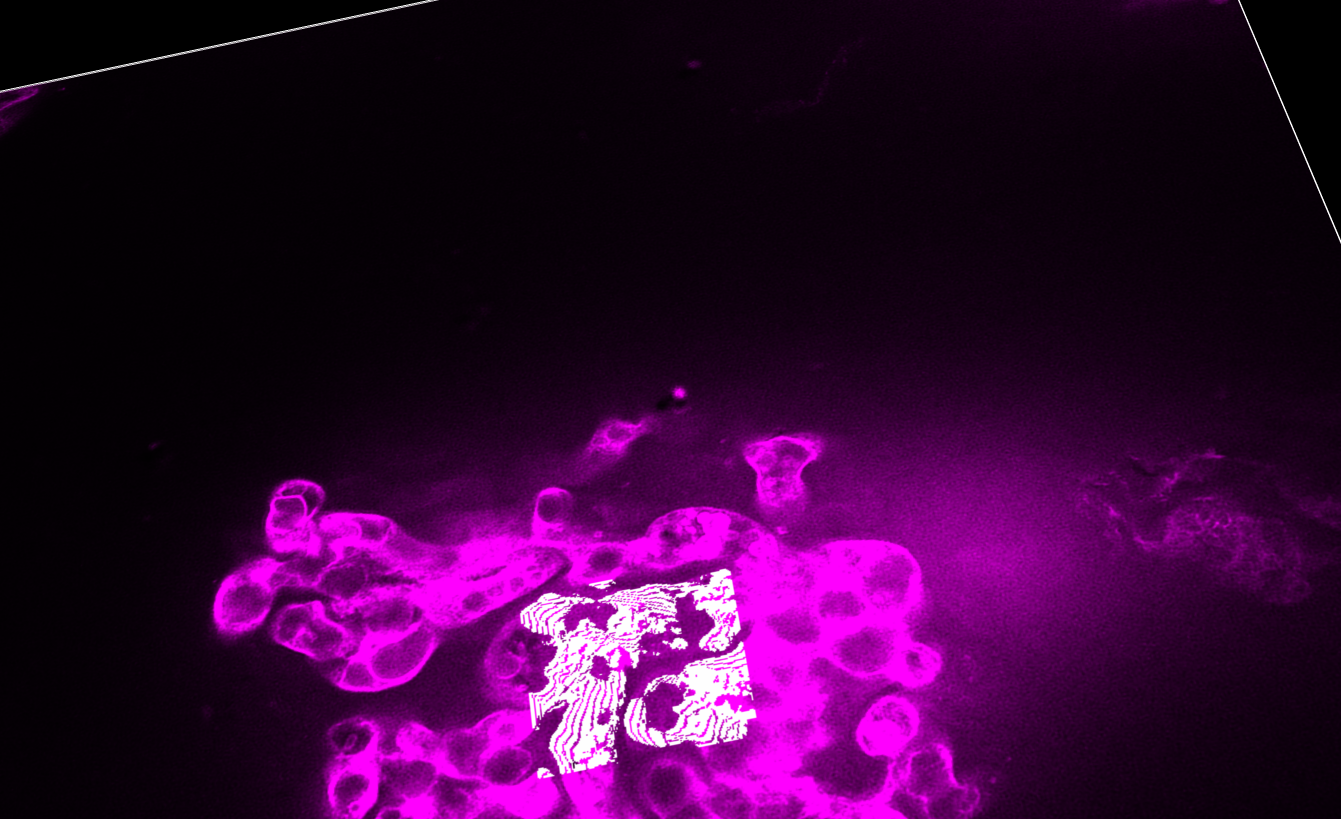

In [ ]:
from scipy import spatial
from numpy import flip as fp

s=time()
y=session.models[2].volume.full_matrix().copy()
p= session.models[3].atoms.coords
p=numpy.round(p).astype('int')

matrix=numpy.zeros((numpy.shape(y)))

a=numpy.linspace(p[0,0]-40,p[0,0]+40, 81)
b=numpy.linspace(p[0,1]-40,p[0,1]+40, 81)
c=numpy.linspace((p[0,2]/1.5)-44,(p[0,2]/1.5)+27, 72)

q=numpy.array(list(itertools.product(*(a,b,c),repeat=1)),dtype='int')
w=numpy.split(q,3,1)
matrix[w[2],w[1],w[0]]=1

cl=numpy.nanmean(y[w[2],w[1],w[0]])*1.15

qtree=scipy.spatial.KDTree(q)
index = qtree.query_ball_point(q, r=3, workers=-1)

"""generates a single 1d array with array 1d index"""

help=numpy.zeros(numpy.shape(y))

for ind in range (0,numpy.shape(index)[0]):
    tz,ty,tx = numpy.split(fp(q[index[ind]],axis=1),3,1)
    
    x,yy,z = q[ind]
    standardD = numpy.nanstd(y[tz,ty,tx])*0.15 
    Thresh= ((numpy.nanmax(y[tz,ty,tx])-numpy.nanmin(y[tz,ty,tx]))/2)+standardD
    contrast= (numpy.nanmax(y[tz,ty,tx])-numpy.nanmin(y[tz,ty,tx])) 

    if (contrast > cl) & (y[z,yy,x] >= Thresh):
        help[z,yy,x] = 1


e=time()
print(e-s)

runs in ~59 sec original script same size ran in ~135 sec

In [ ]:
s=time()
y=session.models[2].volume.full_matrix().copy()
p= session.models[3].atoms.coords

def goop(p):
    n= 50
    p=numpy.round(p).astype('int')

    a=numpy.linspace(p[0,0]-n,p[0,0]+n, n*2)
    b=numpy.linspace(p[0,1]-n,p[0,1]+n, n*2)
    c=numpy.linspace((p[0,2]/1.5)-10,(p[0,2]/1.5)+10, 31)

    q=numpy.array(list(itertools.product(*(a,b,c),repeat=1)),dtype='int')
    w=numpy.split(q,3,1)

    cl=numpy.nanmean(y[w[2],w[1],w[0]])*1.15
    return q, cl

q,cl = goop(p=p)
qtree=scipy.spatial.KDTree(q)
index = qtree.query_ball_point(q, r=3, workers=-1)

"""generates a single 1d array with array 1d index"""

def loop_ROI(q,index):
    help=numpy.zeros(numpy.shape(y))
    for ind in range (0,numpy.shape(index)[0]):
        tz,ty,tx = numpy.split(numpy.flip(q[index[ind]],axis=1),3,1)
        
        x,yy,z = q[ind]
        standardD = numpy.nanstd(y[tz,ty,tx])*0.15 
        Thresh= ((numpy.nanmax(y[tz,ty,tx])-numpy.nanmin(y[tz,ty,tx]))/2)+standardD
        contrast= (numpy.nanmax(y[tz,ty,tx])-numpy.nanmin(y[tz,ty,tx])) 

        help[z,yy,x] = (contrast > cl) * (y[z,yy,x] >= Thresh)
    return help

help = loop_ROI(q = q, index = index)

e=time()
print(e-s)

In [ ]:
mask=ArrayGridData(matrix,step=(1,1,1.5))
volume_from_grid_data(mask,session)

implementing local variable usage as opposed to global varibles (implimenting iterables in functions) increased performance (prior is ~59 current is ~52.3 sec)

In [ ]:
###welp = [(contrast[ind] > cl) & (y[(q[qtree.indices[ind]][2],q[qtree.indices[ind]][1],q[qtree.indices[ind]][0])] >= (Thresh[ind])) for ind in range (0,numpy.shape(index)[0])]

In [ ]:
tz,ty,tx = [numpy.split(fp(q[index[ind]],axis=1),3,1) for ind in range range (0,numpy.shape(index)[0])]


movie record;
view 1;
wait 1;
view 2 36;
wait 36;
view 3 36;
wait 36;
view 1 36;
wait 36;
crossfade 24;
volume #2 style mesh;
wait 24;
view 2 36;
wait 36;
view 3 36;
wait 36;
view 1 36;
wait 36;
crossfade 24;
volume #2 style surface;
wait 24;

In [ ]:
'''sauvola method'''
s=time()
y=session.models[2].volume.full_matrix().copy()
p= session.models[3].atoms.coords

def goop(p):
    n= 50
    p=numpy.round(p).astype('int')

    a=numpy.linspace(p[0,0]-n,p[0,0]+n, n*2)
    b=numpy.linspace(p[0,1]-n,p[0,1]+n, n*2)
    c=numpy.linspace((p[0,2]/1.5)-15,(p[0,2]/1.5)+15, 31)

    q=numpy.array(list(itertools.product(*(a,b,c),repeat=1)),dtype='int')
    w=numpy.split(q,3,1)

    cl=numpy.nanmean(y[w[2],w[1],w[0]])*1.15
    return q, cl

q,cl = goop(p=p)
qtree=scipy.spatial.KDTree(q)
index = qtree.query_ball_point(q, r=3, workers=-1)

"""generates a single 1d array with array 1d index"""

def loop_ROI(q,index):
    help=numpy.zeros(numpy.shape(y))
    for ind in range (0,numpy.shape(index)[0]):
        tz,ty,tx = numpy.split(numpy.flip(q[index[ind]],axis=1),3,1)
        
        x,yy,z = q[ind]
        standardD = numpy.nanstd(y[tz,ty,tx])
        mean=numpy.nanmean(y[tz,ty,tx])
        """Thresh= ((numpy.nanmax(y[tz,ty,tx])-numpy.nanmin(y[tz,ty,tx]))/2)+standardD
        contrast= (numpy.nanmax(y[tz,ty,tx])-numpy.nanmin(y[tz,ty,tx])) """
        Vola= mean * (1+ 0.5 *((standardD/(2^16))-1))
        help[z,yy,x] = (y[z,yy,x] >= Vola)
    return help

help = loop_ROI(q = q, index = index)

e=time()
print(e-s)

Sauvola method fails to find membrane edges in interlaced regions

In [ ]:
(Odd bernsen method of local thresholding with weighted min/max thresholding gate)
s=time()
y=session.models[2].volume.full_matrix().copy()
p= session.models[3].atoms.coords

def goop(p):
    n= 50
    p=numpy.round(p).astype('int')

    a=numpy.linspace(p[0,0]-n,p[0,0]+n, n*2)
    b=numpy.linspace(p[0,1]-n,p[0,1]+n, n*2)
    c=numpy.linspace((p[0,2]/1.5)-10,(p[0,2]/1.5)+15, 36)

    q=numpy.array(list(itertools.product(*(a,b,c),repeat=1)),dtype='int')
    w=numpy.split(q,3,1)

    cl=numpy.nanmean(y[w[2],w[1],w[0]])*1.15
    return q, cl

q,cl = goop(p=p)
qtree=scipy.spatial.KDTree(q)
index = qtree.query_ball_point(q, r=2, workers=-1)

"""generates a single 1d array with array 1d index"""

def loop_ROI(q,index):
    help=numpy.zeros(numpy.shape(y))
    for ind in range (0,numpy.shape(index)[0]):
        tz,ty,tx = numpy.split(numpy.flip(q[index[ind]],axis=1),3,1)

        x,yy,z = q[ind]
        standardD = numpy.nanstd(y[tz,ty,tx])*0.15 
        Thresh= (0.7*(numpy.nanmax(y[tz,ty,tx])+0.3*numpy.nanmin(y[tz,ty,tx]))/2)+standardD
        contrast= (numpy.nanmax(y[tz,ty,tx])-numpy.nanmin(y[tz,ty,tx])) - standardD

        help[z,yy,x] = (contrast > cl) * (y[z,yy,x] >= Thresh)
    return help

help = loop_ROI(q = q, index = index)

e=time()
print(e-s)

In [ ]:
s=time()
y=session.models[2].volume.full_matrix().copy()
p= session.models[3].atoms.coords

def goop(p):
    n= 50
    p=numpy.round(p).astype('int')

    a=numpy.linspace(p[0,0]-n,p[0,0]+n, n*2)
    b=numpy.linspace(p[0,1]-n,p[0,1]+n, n*2)
    c=numpy.linspace((p[0,2]/1.5)-10,(p[0,2]/1.5)+15, 36)

    q=numpy.array(list(itertools.product(*(a,b,c),repeat=1)),dtype='int')
    w=numpy.split(q,3,1)

    cl=numpy.nanmean(y[w[2],w[1],w[0]])*1.15
    return q, cl

q,cl = goop(p=p)
qtree=scipy.spatial.KDTree(q)
index = qtree.query_ball_point(q, r=2, workers=-1)

"""generates a single 1d array with array 1d index"""

def loop_ROI(q,index):
    help=numpy.zeros(numpy.shape(y))
    for ind in range (0,numpy.shape(index)[0]):
        tz,ty,tx = numpy.split(numpy.flip(q[index[ind]],axis=1),3,1)

        x,yy,z = q[ind]
        standardD = numpy.nanstd(y[tz,ty,tx])*0.15 
        Thresh= (0.7*(numpy.nanmax(y[tz,ty,tx])+0.3*numpy.nanmin(y[tz,ty,tx]))/2)+standardD
        contrast= (numpy.nanmax(y[tz,ty,tx])-numpy.nanmin(y[tz,ty,tx])) - standardD

        help[z,yy,x] = (contrast > cl) * (y[z,yy,x] >= Thresh)
    return help

help = loop_ROI(q = q, index = index)

e=time()
print(e-s)

In [ ]:
s=time()
y=session.models[3].volume.full_matrix().copy()
p= session.models[4].atoms.coords
bg=450
def goop(p):
    n= 75
    p=numpy.round(p).astype('int')

    a=numpy.linspace(p[0,0]-n,p[0,0]+n, n*2)
    b=numpy.linspace(p[0,1]-n,p[0,1]+n, n*2)
    c=numpy.linspace((p[0,2]/1.5)-15,(p[0,2]/1.5)+15, 31)

    q=numpy.array(list(itertools.product(*(a,b,c),repeat=1)),dtype='int')
    w=numpy.split(q,3,1)

    cl=numpy.nanmean(y[w[2],w[1],w[0]])*1.15
    return q, cl

q,cl = goop(p=p)
qtree=scipy.spatial.KDTree(q)
index = qtree.query_ball_point(q, r=3, workers=-1)

"""generates a single 1d array with array 1d index"""
'''Smoothing to keep a nice surface'''
tl=y-(numpy.zeros(numpy.shape(y))+bg)
mask = (tl>0)
l=scipy.ndimage.gaussian_filter(tl,sigma=.3,truncate=8)*mask
def loop_ROI(q,index,l,mask):
    help=numpy.zeros(numpy.shape(y))
    telp=numpy.zeros(numpy.shape(y))
    for ind in range (0,numpy.shape(index)[0]):
        tz,ty,tx = numpy.split(numpy.flip(q[index[ind]],axis=1),3,1)

        x,yy,z = q[ind]
        standardD = numpy.nanstd(l[tz,ty,tx])*0.15 
        Thresh= ((numpy.nanmax(l[tz,ty,tx])-numpy.nanmin(l[tz,ty,tx]))/2)+standardD
        contrast= (numpy.nanmax(l[tz,ty,tx])-numpy.nanmin(l[tz,ty,tx])) 

        help[z,yy,x] = (contrast < cl) * (l[z,yy,x] >= Thresh)
        telp[z,yy,x] = help[z,yy,x]*mask[z,yy,x]
    return telp

telp = loop_ROI(q = q, index = index,l=l,mask=mask)

e=time()
print(e-s)

In [ ]:
mask=ArrayGridData(telp,step=(1,1,1.5))
volume_from_grid_data(mask,session)

Most recent implimentation of the bersen method yeils good local thresholding and cappilarry reconstruction in the z axis
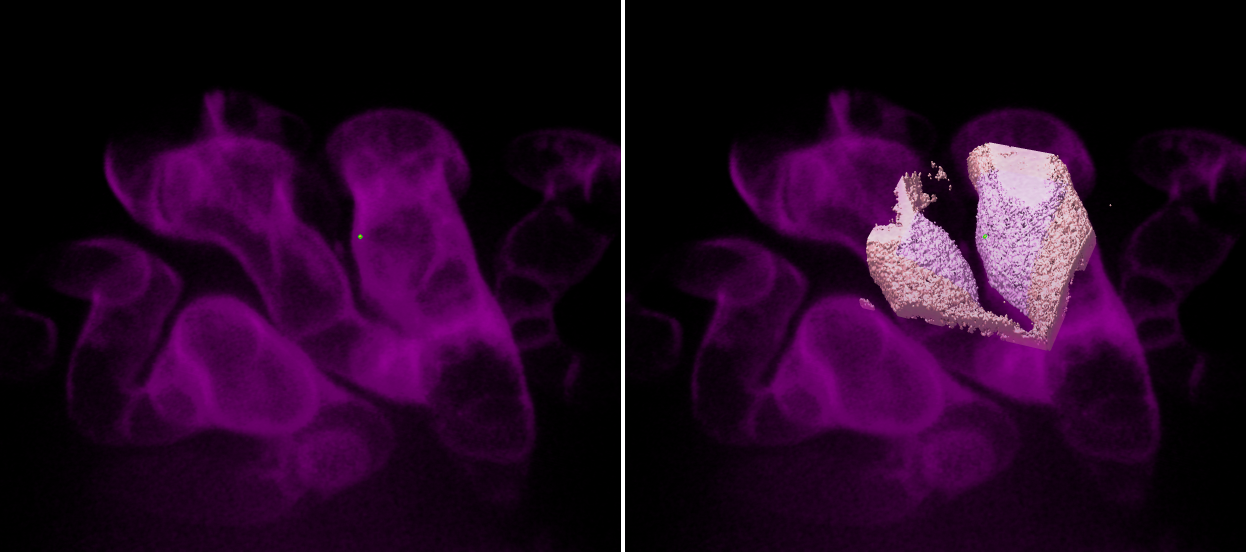

Modifiying to move into a automatick sliding box thresholding for full ROI

In [ ]:
s=time()
y=session.models[2].volume.full_matrix().copy()
iu= session.models[3].atoms.coords
bg=450

def goop(p):
    n= 10

    p=numpy.round(p).astype('int')

    a=numpy.linspace(p[0]-n,p[0]+n, n*2)
    b=numpy.linspace(p[1]-n,p[1]+n, n*2)
    c=numpy.linspace(0,(numpy.shape(y))[0]-1, (numpy.shape(y)[0])-1)

    q=numpy.array(list(itertools.product(*(a,b,c),repeat=1)),dtype='int')
    w=numpy.split(q,3,1)

    cl=numpy.nanmean(y[w[2],w[1],w[0]])*1.5
    return q, cl

def loop_ROI(q,index,l,mask):
    help=numpy.zeros(numpy.shape(y))
    telp=numpy.zeros(numpy.shape(y))
    for ind in range (0,numpy.shape(index)[0]):
        tz,ty,tx = numpy.split(numpy.flip(q[index[ind]],axis=1),3,1)

        x,yy,z = q[ind]
        standardD = numpy.nanstd(l[tz,ty,tx])*0.15 
        Thresh= ((numpy.nanmax(l[tz,ty,tx])-numpy.nanmin(l[tz,ty,tx]))/2)+standardD
        contrast= (numpy.nanmax(l[tz,ty,tx])-numpy.nanmin(l[tz,ty,tx])) 

        help[z,yy,x] = (contrast < cl) * (l[z,yy,x] >= Thresh)
        telp[z,yy,x] = help[z,yy,x]*mask[z,yy,x]
    return telp

elp=numpy.zeros(numpy.shape(y))
for iu in range (0,numpy.shape(p)[0]):
    q,cl = goop(p=p[iu,:])
    qtree=scipy.spatial.KDTree(q)
    index = qtree.query_ball_point(q, r=3, workers=-1)
    """generates a single 1d array with array 1d index"""

    tl=y-(numpy.zeros(numpy.shape(y))+bg)
    mask = (tl>0)

    '''Smoothing to keep a nice surface'''

    l=scipy.ndimage.gaussian_filter(tl,sigma=.3,truncate=8)*mask
    telp = loop_ROI(q = q, index = index,l=l,mask=mask)
    
    elp = (telp+elp)>0
e=time()
print(e-s)

In [ ]:
s=time()
y=session.models[2].volume.full_matrix().copy()
p= session.models[3].atoms.coords
bg=450

def goop(p):
    n= 50

    p=numpy.round(p).astype('int')

    a=numpy.linspace(p[0]-n,p[0]+n, n*2)
    b=numpy.linspace(p[1]-n,p[1]+n, n*2)
    c=numpy.linspace(0,(numpy.shape(y))[0]-1, (numpy.shape(y)[0]-1))

    q=numpy.array(list(itertools.product(*(a,b,c),repeat=1)),dtype='int')
    w=numpy.split(q,3,1)

    cl=numpy.nanmean(y[w[2],w[1],w[0]])*1.5
    return q, cl

def loop_ROI(q,index,l,mask):
    help=numpy.zeros(numpy.shape(y))
    telp=numpy.zeros(numpy.shape(y))
    for ind in range (0,numpy.shape(index)[0]):
        tz,ty,tx = numpy.split(numpy.flip(q[index[ind]],axis=1),3,1)

        x,yy,z = q[ind]
        standardD = numpy.nanstd(l[tz,ty,tx])*0.15
        Thresh= ((numpy.nanmax(l[tz,ty,tx].8)-numpy.nanmin(l[tz,ty,tx]))/2)+standardD
        contrast= (numpy.nanmax(l[tz,ty,tx])-numpy.nanmin(l[tz,ty,tx])) 

        help[z,yy,x] = (contrast < cl) * (l[z,yy,x] >= Thresh)
        telp[z,yy,x] = help[z,yy,x]*mask[z,yy,x]
    return telp

elp=numpy.zeros(numpy.shape(y))
for iu in range (0,numpy.shape(p)[0]):
    q,cl = goop(p=p[iu,:])
    qtree=scipy.spatial.KDTree(q)
    index = qtree.query_ball_point(q, r=3, workers=-1)
    """generates a single 1d array with array 1d index"""

    tl=y-(numpy.zeros(numpy.shape(y))+bg)
    mask = (tl>0)

    '''Smoothing to keep a nice surface'''

    li=scipy.ndimage.gaussian_filter(tl,sigma=.3,truncate=6)*mask
    l=li*(li>((numpy.nanstd(li))+(numpy.nanquantile(li,q=0.85))))   
    telp = loop_ROI(q = q, index = index,l=l,mask=mask)

    elp = (telp+elp)>0
e=time()
print(e-s)

In [ ]:
s=time()
y=session.models[2].volume.full_matrix().copy()
p= session.models[3].atoms.coords
bg=450

def goop(p):
    n= 60

    p=numpy.round(p).astype('int')

    a=numpy.linspace(p[0]-n,p[0]+n, n*2)
    b=numpy.linspace(p[1]-n,p[1]+n, n*2)
    c=numpy.linspace(0,(numpy.shape(y))[0]-1, (numpy.shape(y)[0]-1))

    q=numpy.array(list(itertools.product(*(a,b,c),repeat=1)),dtype='int')
    w=numpy.split(q,3,1)

    cl=numpy.nanmean(l[w[2],w[1],w[0]])*.2
    return q, cl

def loop_ROI(q,index,l,mask):
    help=numpy.zeros(numpy.shape(y))
    telp=numpy.zeros(numpy.shape(y))
    for ind in range (0,numpy.shape(index)[0]):
        tz,ty,tx = numpy.split(numpy.flip(q[index[ind]],axis=1),3,1)

        x,yy,z = q[ind]
        if numpy.all(numpy.isnan(l[tz,ty,tx]))==0:
            standardD = numpy.nanstd(l[tz,ty,tx])*0.15
            Thresh= ((numpy.nanmax(l[tz,ty,tx])-numpy.nanmin(l[tz,ty,tx])*1.15)/2)+standardD
            contrast= (numpy.nanmax(l[tz,ty,tx])-numpy.nanmin(l[tz,ty,tx])) 

            help[z,yy,x] = (contrast >= cl) * (l[z,yy,x] >= Thresh)
            telp[z,yy,x] = help[z,yy,x]*mask[z,yy,x]
        else:
            telp[z,yy,x]=0
    return telp

elp=numpy.zeros(numpy.shape(y))
tl=y-(numpy.zeros(numpy.shape(y))+bg)
mask = (tl>0)
li=scipy.ndimage.gaussian_filter(tl,sigma=.4,truncate=5)*mask
lp=li*(li>((numpy.nanstd(li))+(numpy.nanquantile(li,q=0.85))))   
l=lp
l[l==0]=numpy.nan
for iu in range (0,numpy.shape(p)[0]):
    q,cl = goop(p=p[iu,:])
    qtree=scipy.spatial.KDTree(q)
    index = qtree.query_ball_point(q, r=3, workers=-1)
    """generates a single 1d array with array 1d index"""

    '''Smoothing to keep a nice surface'''

    
    telp = loop_ROI(q = q, index = index,l=l,mask=mask)

    elp = (telp+elp)>0
e=time()
print(e-s)

open C:\Users\LoydY\Documents\917_006\006_decon_capillaries.tif format images